In [2]:
import pandas as pd 
import numpy as np 
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import datetime

In [3]:
class MarketInsights():
    
    
    def __init__(self):
        """
        Open Database
        
        """
        client = MongoClient('localhost', 27017)
        db = client.AmazonFBA
        
        collection = db.Sales
        self.collection = collection 
        
        collection_2 = db.DailyPpcCost
        self.collection_2 = collection_2

        collection_3 = db.PpcGebühren
        self.collection_3 = collection_3
        
        collection_4 = db.Lagergebühren
        self.collection_4 = collection_4
  
        collection_5 = db.AmazonGebühren
        self.collection_5 = collection_5
        
    def tägliche_verkäufe(self): 
        """
        Shows total sales of each day in a Pandas DataFrame
        
        """
        result = list(self.collection.aggregate([
            # Group the documents and "count" via $sum on the values
            { "$group": {
            "_id": {
                "datum": "$datum",
            },
            "count": { "$sum": 1 }
        }}
        ]))
        
        liste =[]
        for i in result:

            # extract hour for dataframe
            hour = list(list(i.items())[0][1].values())[0]

            # extract occurance for dataframe
            element = (list(i.items())[1])
            occurance = element[1]

            # transform data in to dataframe
            obj = { "Datum" : hour, "Anzahl der Verkäufe" : occurance}
            liste.append(obj)
        df = pd.DataFrame(liste)
        df = df.sort_values(by = "Datum")

        ax = df.plot.bar( x = "Datum", y = "Anzahl der Verkäufe", color ="green")
        
        # to show not all x-labels
        for i, t in enumerate(ax.get_xticklabels()):
            if (i % 7) != 0:
                t.set_visible(False)
    
    
    def analyse_der_besten_verkaufszeiten(self): 
        """
        Shows chart of total sales based on the hour of a day
        
        """
        result = list(self.collection.aggregate([
            # Group the documents and "count" via $sum on the values
            { "$group": {
            "_id": {
                "stunde": "$stunde",
            },
            "count": { "$sum": 1 }}}
        ]))
        liste =[]
        
        for i in result:

            # extract hour for dataframe
            hour = list(list(i.items())[0][1].values())[0]

            # extract occurance for dataframe
            element = (list(i.items())[1])
            occurance = element[1]

            # transform data in to dataframe
            obj = { "Uhrzeit" : hour, "Anzahl der Verkäufe" : occurance}
            liste.append(obj)

        df = pd.DataFrame(liste)
        df = df.sort_values(by = "Uhrzeit")
        df.plot.bar( x = "Uhrzeit", y = "Anzahl der Verkäufe", color ="green")
    
    
    def chart_gewinn_gegenüber_ppc_ausgaben(self):
        """
        Create Blueprint

        """

        start = datetime.datetime.strptime("2020-06-01", "%Y-%m-%d")
        end = datetime.datetime.strptime("2020-10-10", "%Y-%m-%d")
        date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

        results = []

        for date in date_generated:
            obj = { 
                "datum" : str(date.strftime("%Y-%m-%d")),
                "reingewinn" : 0,
                "klicks" : 0,
                "kosten_pro_klick" : 0,
                "ausgaben" : 0 
            }
            results.append(obj)

        """
        Query and import Productdata

        """
        gewinn_minus_produktkosten = list(self.collection.aggregate([
                    {
                        "$group": {
                            "_id": {
                                "datum": "$datum"
                            }, 
                        "gewinn_nach_produktkosten": { "$sum": "$gewinn_nach_produktkosten"} },

                    }]))



        # Add data to Blueprint 
        for element in results:
            for obj in gewinn_minus_produktkosten: 
                if list(obj["_id"].values())[0] == element["datum"]: 
                    element["reingewinn"] = round(obj["gewinn_nach_produktkosten"], 2)  


        """
        Query and import PPC Data

        """
        query = [{"datum":{"$gte":"2020-05-01"}}, {"datum":{"$lte":"2020-10-30"}}]
        ppc = list(self.collection_2.aggregate([{"$match":{ "$and": query}}]))

        # Add data to Blueprint 
        for element in results:
            for obj in ppc: 
                if obj["datum"] == element["datum"]:
                    element["klicks"] =obj["klicks"]
                    element["kosten_pro_klick"] = obj["kosten_pro_klick"]
                    element["ausgaben"] = obj["ausgaben"]


        df = pd.DataFrame(results)
        df["gesamtgewinn"] = df["reingewinn"] - df["ausgaben"]

        """
        Plot Data

        """
        ax1 = sns.set_style(style=None, rc=None )
        fig, ax1 = plt.subplots(figsize=(12,6))
        sns.lineplot(data = df['reingewinn'], ax=ax1)
        ax2 = ax1.twinx()
        sns.lineplot(data = df, x='datum', y='ausgaben', alpha=0.5, ax=ax2, color = "red").set_title('Gesamtgewinn (Gewinn-Amazongebühren-Produktkosten) / Tägliche PPC Ausgaben')
        new_ticks = [i.get_text() for i in ax2.get_xticklabels()]
        plt.xticks(range(0, len(new_ticks), 15), new_ticks[::15])
        
        return df
    
    
    def bilanz(self, df): 
        """
        Stellt die Gesamte Einnahmen / Ausgaben als Bilanzchart dar 
        
        """
        ax =  df.plot.bar( x = "datum", y = "gesamtgewinn", color ="green", figsize=(12,8))
        # to show not all x-labels
        for i, t in enumerate(ax.get_xticklabels()):
            if (i % 5) != 0:
                t.set_visible(False)    
                
                
    def ppc_gesamtkosten(self, startdate, enddate):
        query = [{"datum":{"$gte": startdate}}, {"datum":{"$lte": enddate}}]
        ppc = list(self.collection_3.aggregate([{"$match":{ "$and": query}}]))

        kosten = 0
        for obj in ppc: 
            kosten = kosten + obj["kosten"]
        print(f'Die gesamten PPC kosten von {startdate} bis {enddate} betragen: {round(kosten, 2)}€') 
    
    
    def lagergebühren(self, startdate, enddate):
        query = [{"datum":{"$gte": startdate}}, {"datum":{"$lte": enddate}}]
        lagerkosten = list(self.collection_4.aggregate([{"$match":{ "$and": query}}]))

        kosten = 0
        for obj in lagerkosten: 
            kosten = kosten + obj["kosten"]
        print(f'Die gesamten Lagerkosten kosten von {startdate} bis {enddate} betragen: {round(kosten, 2)}€') 
    
    
    def amazon_fee(self, startdate, enddate):
        query = [{"datum":{"$gte": startdate}}, {"datum":{"$lte": enddate}}]
        amazon_fee = list(self.collection_5.aggregate([{"$match":{ "$and": query}}]))

        kosten = 0
        for obj in amazon_fee: 
            kosten = kosten + obj["umsatz"]
        print(f'Die Amazon Fee von {startdate} bis {enddate} betragen: {round(kosten, 2)}€') 

        
    def einnahmen(self, startdate, enddate):
        query = [{"datum":{"$gte": startdate}}, {"datum":{"$lte": enddate}}]
        einnahmen = list(self.collection.aggregate([{"$match":{ "$and": query}}]))

        gewinn = 0
        gewinn_nach_produktkosten = 0 
        for obj in einnahmen: 
            gewinn = gewinn + obj["gewinn"]
            gewinn_nach_produktkosten = gewinn_nach_produktkosten + obj["gewinn_nach_produktkosten"]
        print(f'Der Gesamtgewinn ohne Produktkosten von {startdate} bis {enddate} betragen: {round(gewinn, 2)}€')
        print(f'Der Gesamtgewinn inkl. Produktkosten von {startdate} bis {enddate} betragen: {round(gewinn_nach_produktkosten, 2)}€')
        
        
    def gewinn_pro_box(self, startdate, enddate):
        """
        Noch nicht fertig 
        
        
        """
        query = [{"datum":{"$gte": startdate}}, {"datum":{"$lte": enddate}}]
        einnahmen = list(self.collection.aggregate([{"$match":{ "$and": query}}]))
        ppc = list(self.collection_3.aggregate([{"$match":{ "$and": query}}]))
        lagerkosten = list(self.collection_4.aggregate([{"$match":{ "$and": query}}]))
        amazon_fee = list(self.collection_5.aggregate([{"$match":{ "$and": query}}]))
        
        gewinn_minus_produktkosten = list(self.collection.aggregate([
            {
                "$group": {
                    "_id": {
                        "Verkaufte_Einheiten": "$menge"
                    }, 
                "Anzahl": { "$sum": "$menge"} },

            }]))
        
        print(gewinn_minus_produktkosten)


    def größe_der_bestellungen(self, startdate, enddate):
        bestellungen = list(self.collection.aggregate([
            {
                "$group": {
                    "_id": {
                        "Verkaufte_Einheiten": "$menge"
                    }, 
                "Anzahl": { "$sum": "$menge"} },

            }]))

        return bestellungen

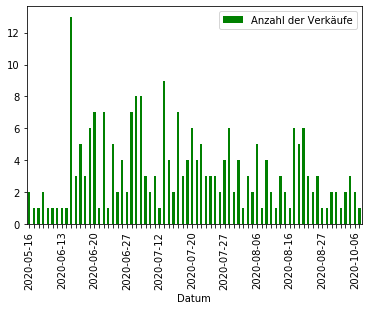

In [6]:
MarketInsights().tägliche_verkäufe()

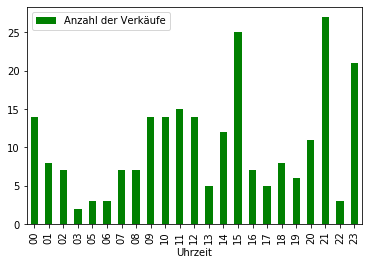

In [7]:
MarketInsights().analyse_der_besten_verkaufszeiten()

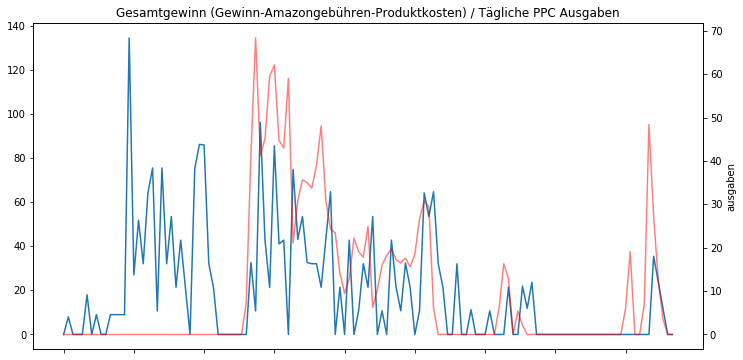

In [8]:
df = MarketInsights().chart_gewinn_gegenüber_ppc_ausgaben()

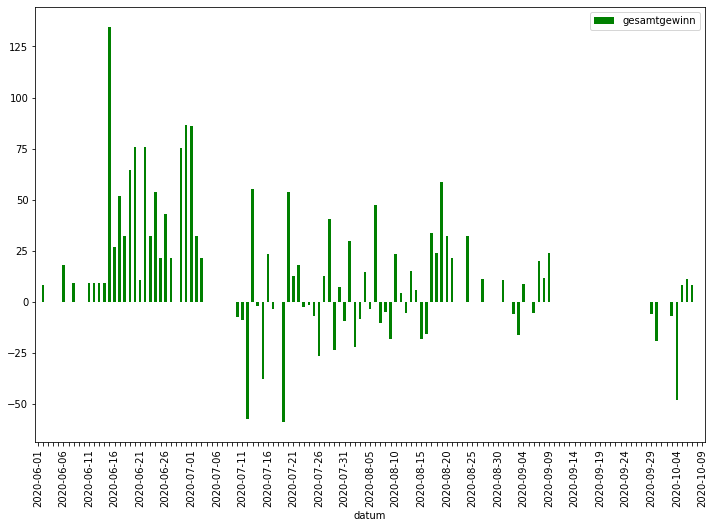

In [19]:
MarketInsights().bilanz(df)

In [6]:
MarketInsights().ppc_gesamtkosten("2020-05-01", "2020-06-30")

Die gesamten PPC kosten von 2020-05-01 bis 2020-06-30 betragen: -981.62€


In [7]:
MarketInsights().lagergebühren("2020-05-01", "2020-06-30")

Die gesamten Lagerkosten kosten von 2020-05-01 bis 2020-06-30 betragen: -17.81€


In [8]:
MarketInsights().amazon_fee("2020-05-01", "2020-06-30")

Die Amazon Fee von 2020-05-01 bis 2020-06-30 betragen: -39.0€


In [9]:
MarketInsights().einnahmen("2020-05-01", "2020-06-30")

Der Gesamtgewinn ohne Produktkosten von 2020-05-01 bis 2020-06-30 betragen: 1206.13€
Der Gesamtgewinn inkl. Produktkosten von 2020-05-01 bis 2020-06-30 betragen: 907.98€


In [10]:
# Arten von Bestellungen
MarketInsights().größe_der_bestellungen("2020-05-01", "2020-06-30")

[{'_id': {'Verkaufte_Einheiten': 3.0}, 'Anzahl': 3.0},
 {'_id': {'Verkaufte_Einheiten': 1.0}, 'Anzahl': 232.0},
 {'_id': {'Verkaufte_Einheiten': 2.0}, 'Anzahl': 10.0}]